# Activity assay

In [20]:
import os
import parse
import glob

import numpy as np
import h5py
from pprint import pprint
from tqdm.auto import tqdm

def convert_folder_to_hdf5(folder, output='../data', **metadata):
    # Find the correct number of files
    num_files = len(glob.glob(f'{folder}/nx*'))
    print(f'{folder} has {num_files} timepoints')

    # Collect the data from files
    director = []
    for i in tqdm(range(1, num_files)):
        nx = np.loadtxt(f'{folder}/nx{i:d}')
        ny = np.loadtxt(f'{folder}/ny{i:d}')
        director.append(np.stack([nx, ny]))
    director = np.stack(director)

    # Save as aggregated hdf5 store
    with h5py.File(f'{output}/{os.path.basename(path)}.hdf5', 'w') as h5f:
        h5f.create_dataset('director', data=director)
        for key in metadata:
            h5f.attrs[key] = metadata[key]


fstring = 'z{:f}'

base_dir = '/project2/vitelli/ml_active_nematics'
data_dir = 'deltat_10s'
for path in os.listdir(f'{base_dir}/{data_dir}'):
    if os.path.isdir(f'{base_dir}/{data_dir}/{path}'):
        try:
            z = parse.parse(fstring, path)[0]
        except:
            z = 0.

        print(f'Directory {path}, z = {z:.03f}')
        convert_folder_to_hdf5(f'{base_dir}/{data_dir}/{path}', output='../../data/activity_assay', z=z)

Directory z0.015, z = 0.015
/project2/vitelli/ml_active_nematics/deltat_10s/z0.015 has 601 timepoints


100%|██████████| 600/600 [00:03<00:00, 152.55it/s]


Directory z0.001, z = 0.001
/project2/vitelli/ml_active_nematics/deltat_10s/z0.001 has 601 timepoints


100%|██████████| 600/600 [00:03<00:00, 155.41it/s]


Directory z0.025, z = 0.025
/project2/vitelli/ml_active_nematics/deltat_10s/z0.025 has 601 timepoints


100%|██████████| 600/600 [00:34<00:00, 17.49it/s]


Directory z0.03, z = 0.030
/project2/vitelli/ml_active_nematics/deltat_10s/z0.03 has 601 timepoints


100%|██████████| 600/600 [00:34<00:00, 17.63it/s]


Directory z0.01, z = 0.010
/project2/vitelli/ml_active_nematics/deltat_10s/z0.01 has 601 timepoints


100%|██████████| 600/600 [00:33<00:00, 17.93it/s]


Directory z0, z = 0.000
/project2/vitelli/ml_active_nematics/deltat_10s/z0 has 601 timepoints


100%|██████████| 600/600 [00:35<00:00, 16.91it/s]


Directory z0.04, z = 0.040
/project2/vitelli/ml_active_nematics/deltat_10s/z0.04 has 601 timepoints


100%|██████████| 600/600 [00:35<00:00, 17.14it/s]


Directory z0.005, z = 0.005
/project2/vitelli/ml_active_nematics/deltat_10s/z0.005 has 601 timepoints


100%|██████████| 600/600 [00:35<00:00, 16.86it/s]


Directory z0.035, z = 0.035
/project2/vitelli/ml_active_nematics/deltat_10s/z0.035 has 601 timepoints


100%|██████████| 600/600 [00:34<00:00, 17.41it/s]


Directory z0.002, z = 0.002
/project2/vitelli/ml_active_nematics/deltat_10s/z0.002 has 601 timepoints


100%|██████████| 600/600 [00:35<00:00, 17.09it/s]


Directory z0.02, z = 0.020
/project2/vitelli/ml_active_nematics/deltat_10s/z0.02 has 601 timepoints


100%|██████████| 600/600 [00:31<00:00, 19.29it/s]


Directory z0.05, z = 0.050
/project2/vitelli/ml_active_nematics/deltat_10s/z0.05 has 601 timepoints


100%|██████████| 600/600 [00:25<00:00, 23.22it/s]


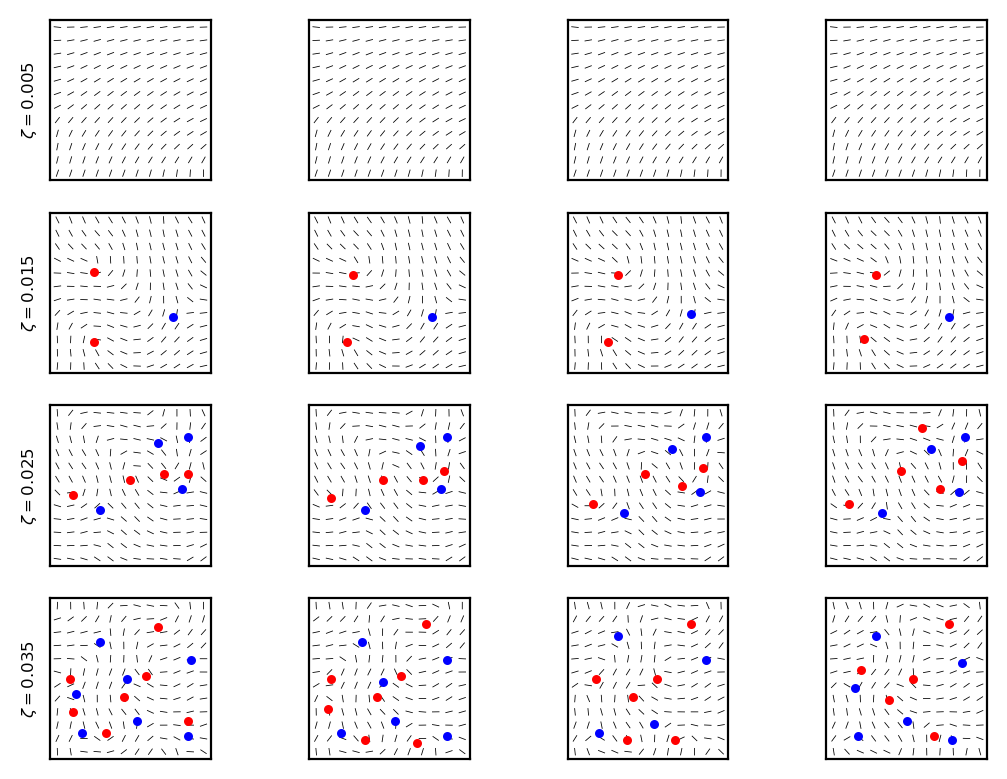

In [1]:
import sys
sys.path.insert(0, '../src')

from skimage.transform import downscale_local_mean
from scipy.interpolate import interp2d
from defects import defect_coordinates
from winding import winding
from tqdm import tqdm
import h5py

import matplotlib.pyplot as plt
import numpy as np

activities = ['z0.005', 'z0.015', 'z0.025', 'z0.035']
fig, ax = plt.subplots(4, 4, dpi=200)

skip = 4
size = 48
slc = np.s_[:, :, 32:32+size, 32:32+size]

x2, y2 = np.meshgrid(np.linspace(0, 1, size//skip),
                     np.linspace(0, 1, size//skip))

for j, act in enumerate(activities):
    with h5py.File(f'../../data/activity_assay/{act}.hdf5', 'r') as h5f:
        director = h5f['director'][slc]

        for i in range(4):
            ax[j,i].quiver(x2, y2, 
                           director[i,0, ::skip, ::skip], 
                           director[i,1, ::skip, ::skip], 
                           pivot='middle',
                           headwidth=0, headlength=0, headaxislength=0)
            Q = np.einsum('ixy,jxy->ijxy', director[i], director[i])
            twoT = np.arctan2(Q[0, 0] - Q[1, 1], 2 * Q[0, 1])
            theta = twoT / 2
            theta[theta < 0] += np.pi
            theta[theta > np.pi] -= np.pi
            
            defs = defect_coordinates(theta)
            wind = winding(theta)
            charge = wind[defs[:, 1], defs[:, 0]]
            defs = defs / size
            
            ax[j,i].scatter(defs[charge > 0, 0], defs[charge > 0, 1], color='red', s=5)
            ax[j,i].scatter(defs[charge < 0, 0], defs[charge < 0, 1], color='blue', s=5)
            ax[j,i].set(xticks=[], yticks=[], aspect='equal')
        ax[j,0].set_ylabel(f'$\\zeta = {h5f.attrs["z"]:.03f}$', fontsize=6)